# Purpose
This notebooks builds a global and local discriminator model.

# Import

In [1]:
import pandas as pd
import torch

from glcic.networks.discriminators import *
from glcic.utils import *

# Discriminators

## Global discriminator

In [2]:
# architecture
gd_layers_params = pd.read_pickle("../lib/glcic/networks/gd_layers_params.p")
gd_layers_params

,type,kernel,dilatation,stride,inputs,outputs,batchnorm,activation
0,conv,5,1,2,3,64,True,ReLU
1,conv,5,1,2,64,128,True,ReLU
2,conv,5,1,2,128,256,True,ReLU
3,conv,5,1,2,256,512,True,ReLU
4,conv,5,1,2,512,512,True,ReLU
5,conv,5,1,2,512,512,True,ReLU


In [3]:
# vizualize
gd = GlobalDiscriminator()
x = torch.randn(2, 3, 256, 256)
y = gd(x)
from torchviz import make_dot
make_dot(y, params=dict(gd.named_parameters()))

ModuleNotFoundError: No module named 'torchviz'

## Local discriminator

In [ ]:
# architecture
ld_layers_params = pd.read_pickle("../lib/glcic/networks/ld_layers_params.p")
ld_layers_params

,type,kernel,dilatation,stride,inputs,outputs,batchnorm,activation
0,conv,5,1,2,3,64,True,ReLU
1,conv,5,1,2,64,128,True,ReLU
2,conv,5,1,2,128,256,True,ReLU
3,conv,5,1,2,256,512,True,ReLU
4,conv,5,1,2,512,512,True,ReLU


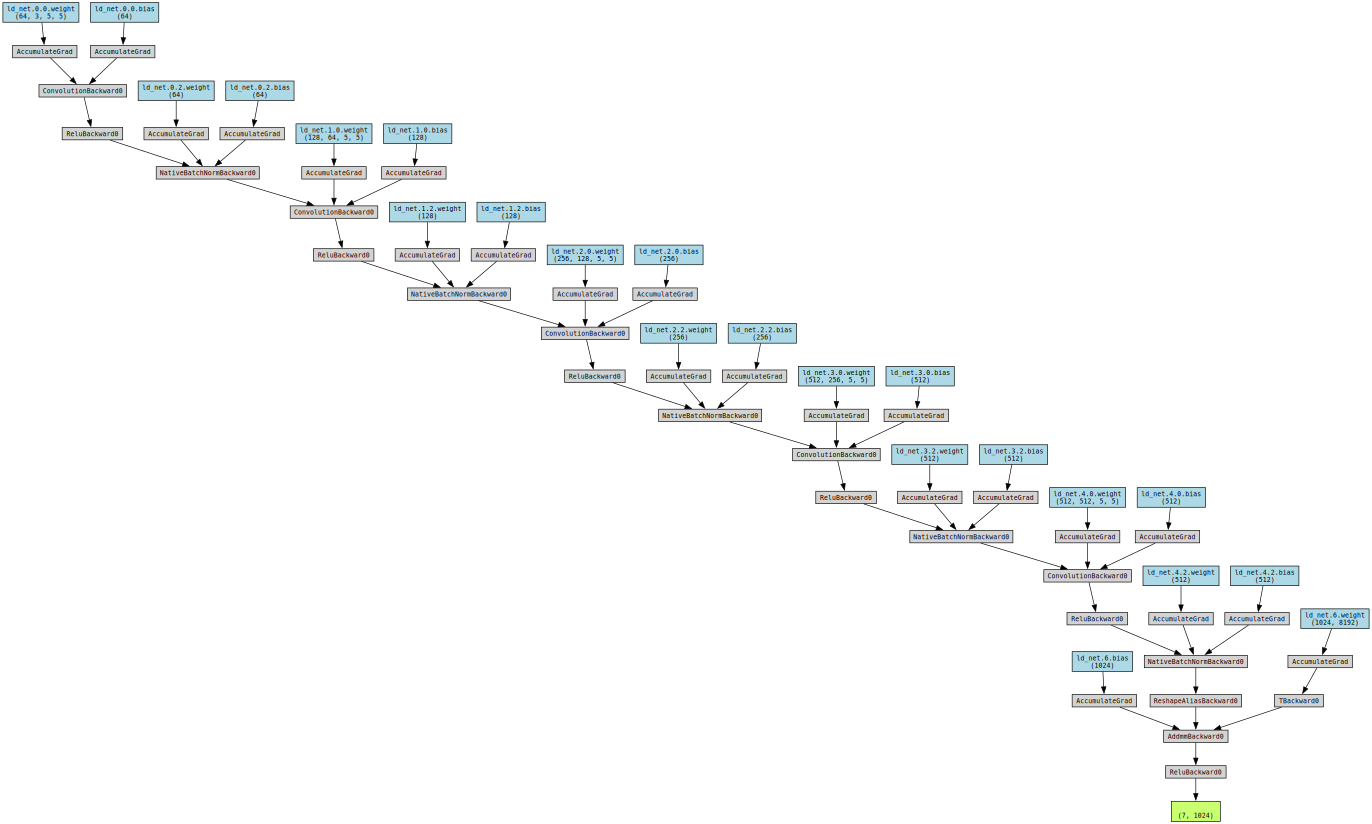

In [ ]:
# vizualize
ld = LocalDiscriminator()
local_x = torch.randn(7, 3, 128, 128)
y = ld(local_x)
from torchviz import make_dot
make_dot(y, params=dict(ld.named_parameters()))

# Save and load

In [ ]:
ld.save("../logs/models/ld")
gd.save("../logs/models/gd")

Save: state_dict saved in ../logs/models/ld
Save: state_dict saved in ../logs/models/gd


In [ ]:
ld.load("../logs/models/ld")
gd.load("../logs/models/gd")

Load: load_state dict from ../logs/models/ld
Load: load_state dict from ../logs/models/gd


# Full discriminators

In [5]:
# load the dataset
batch_size = 4
train_dataset_dir = '../data/train/'
train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_dir, transform=torchvision.transforms.ToTensor())
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# first batch
batch = next(iter(train_dataloader))[0]
lm,em = generate_mask(batch_size)
replacement_val = torch.tensor([0.5062325495504219, 0.4255871700324652, 0.38299278586700136])
masked_batch = apply_mask(batch,em,replacement_val)

In [6]:
# full discriminator
discriminator = Discriminator()
prediction = discriminator(masked_batch,lm)
print("Prediction is: ",prediction)

Prediction is:  tensor([[0.5264],
        [0.4921],
        [0.4003],
        [0.5961]], grad_fn=<SigmoidBackward0>)


# Training

In [7]:
from glcic.trainers.discriminator_trainer import train_discriminator

In [8]:
# set up
cn = CompletionNetwork()
cn.load("../logs/models/cn_scrapped_weights")
optimizer = torch.optim.Adadelta(discriminator.parameters())

# hyperparameters
num_batch = 10
replacement_val = torch.tensor([0.5062325495504219, 0.4255871700324652, 0.38299278586700136])

Load: load_state dict from ../logs/models/cn_scrapped_weights


In [9]:
# train
loss_list = train_discriminator(discriminator, cn,
    optimizer,train_dataloader,
    num_batch, replacement_val)


### BATCH 1/10 ###
loss: 0.6494102478027344 for non-completed images, 1.4093741178512573 for completed images

### BATCH 2/10 ###
loss: 1.01314377784729 for non-completed images, 1.888562798500061 for completed images

### BATCH 3/10 ###
loss: 4.8862996101379395 for non-completed images, 36.726585388183594 for completed images

### BATCH 4/10 ###
loss: 16.271865844726562 for non-completed images, 17.469772338867188 for completed images

### BATCH 5/10 ###
loss: 12.172982215881348 for non-completed images, 17.03897476196289 for completed images

### BATCH 6/10 ###
loss: 13.724706649780273 for non-completed images, 19.620590209960938 for completed images

### BATCH 7/10 ###
loss: 28.35707664489746 for non-completed images, 28.35716438293457 for completed images

### BATCH 8/10 ###
loss: 5.320190906524658 for non-completed images, 8.006155014038086 for completed images

### BATCH 9/10 ###
loss: 8.489277839660645 for non-completed images, 10.142032623291016 for completed images

### BATCH

In [10]:
# save checkpoint
resume_path = update_resume_path(train_dataset_dir, "../data/train/barn/00001032.jpg", num_batch, 4)
save_checkpoint("../logs/phase2_checkpoints/",
    discriminator,
    optimizer,
    [loss_list],
    num_batch,
    resume_path,
    replacement_val)

# Monitor the training

Total number of batch:  10
Path to resume training:  ../data/train/barn/00001072.jpg
Current replacement value:  tensor([0.5062, 0.4257, 0.3831])


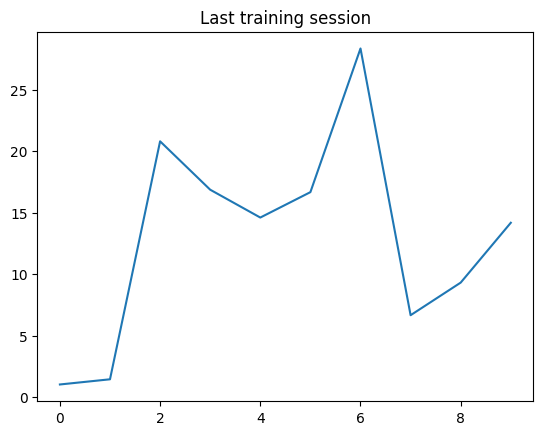

In [11]:
# set up
discriminator = Discriminator()
optimizer = torch.optim.Adadelta(discriminator.parameters())

# last training session
loss_list, batch, resume_path, replacement_val = load_checkpoint(
        "../logs/phase2_checkpoints/", discriminator, optimizer
    )

import matplotlib.pyplot as plt
plt.plot(loss_list[-1])
plt.title("Last training session")

print("Total number of batch: ",batch)
print("Path to resume training: ",resume_path)
print("Current replacement value: ",replacement_val)

Text(0.5, 1.0, 'CN training\n Smoothed loss')

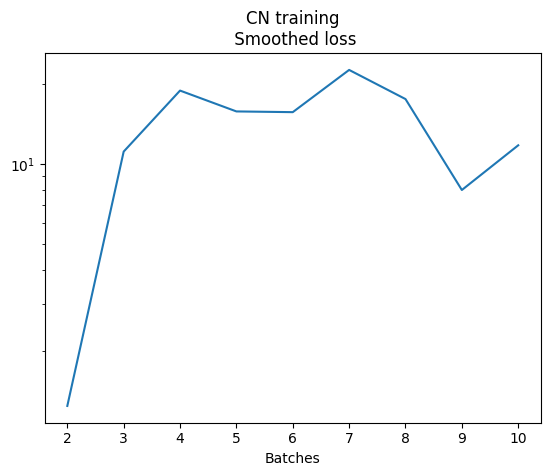

In [13]:
# full training
concatenated_loss_list = []
for loss in loss_list:
    concatenated_loss_list += loss
    
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

smooth_pts = 2 # 100
plt.semilogy(range(smooth_pts,len(concatenated_loss_list)+1),smooth(concatenated_loss_list,smooth_pts))
plt.xlabel("Batches")
plt.title("CN training\n Smoothed loss")

In [15]:
# estimated time
checkpoints_dir = "../logs/phase2_checkpoints/"
files = os.listdir("../logs/phase2_checkpoints/")

# sort by days
days = {}
for file in files:
    day = file[6:8]
    if day in days:
        days[day]+=[file]
    else:
        days[day]=[file]

# compute training time
total_training_time = 0
for checkpoints_list in days.values():
    ctimes = [os.path.getctime(checkpoints_dir+file) for file in checkpoints_list]
    total_training_time += max(ctimes)-min(ctimes)
print(f"Total training time is {int(total_training_time/3600)} hours")

Total training time is 7 hours


In [17]:
# estimated time left
checkpoints_dir = "../logs/phase2_checkpoints/"
files = os.listdir("../logs/phase2_checkpoints/")
file1 = checkpoints_dir+files[-2]
file2 = checkpoints_dir+files[-1]
checkpoint1 = torch.load(file1)
checkpoint2 = torch.load(file2)
batch1 =checkpoint1["batch"]
batch2 =checkpoint2["batch"]
time1 = os.path.getctime(file1)
time2 = os.path.getctime(file2)
average_batch_time = (time2-time1)/(batch2-batch1)
estimated_time = (10000-batch2)*average_batch_time

print(f"{estimated_time/3600} hours left")
print(f"{estimated_time/(24*3600)} days left")

52.987417799459564 hours left
2.2078090749774817 days left
